In [1]:
import pandas as pd
import pickle as pkl
import pingouin as pg
from pathlib import Path
from notebook_script import *
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root = Path('//folder/becell/Lab Projects/ERCstG_HighMemory/Data/Marc/1_SOC/2_ProtocolSexAge/')
directory = root / "MoSeq/2024_05_23-11_06_49/results"
conditions_dir = root

# Upload the conditions
txt_path = conditions_dir / "DeepOF/conditions.csv"
target_values = pd.read_csv(txt_path)

In [ ]:
blue = '#194680'
red = '#801946'
grey = '#636466'

specifics_transmatrix = {'learning': 'direct'}
specifics_bootstrap = ['group']
time_period = 'ON'

if time_period == 'ON':
    num = 3
elif time_period == 'OFF':
    num = 2

In [ ]:
# Generate all paired combinations
specifics_bootstrap = ['sex', 'age']
target_values["group"] = target_values[specifics_bootstrap].apply("_".join, axis=1)

In [ ]:
syllables_dict = filter_data(specifics_transmatrix, directory, 6, num, target_values)

In [ ]:
transition_dict, _ = create_transition_dict(syllables_dict, silence_diagonal=True, normalize=False)

In [ ]:
behavior_bootstrap(transition_dict, target_values, 'group')

In [ ]:
stats_df = pairwise_behavior_bootstrap(transition_dict, target_values, 'group')
stats_df.to_csv(f'C:/Users/mcanela/Desktop/stats_{time_period}_direct.csv', index=False)

In [3]:
# specific_combinations = {
#     'paired': ['paired'],
#     'unpaired': ['unpaired'],
#     'no-shock': ['no-shock'],
# }

specific_combinations = {
    'young_males': ['male_young'],
    'young_females': ['female_young'],
    'old_males': ['male_old'],
    'old_females': ['female_old'],
}

# specific_combinations = {
#     'paired': ['yes'],
#     'no': ['no'],
# }

custom_labels = {
    'mediated_2': 'Before the tone',
    'mediated_3': 'During the tone (Mediated)',
    'direct_2': 'Before the light',
    'direct_3': 'During the light (Direct)',
}

## Plot stationary distribution combined

In [ ]:
stationary_dict = compute_stationary_dict(specific_combinations, syllables_dict, target_values)
data = plot_stationary_distribution(stationary_dict)

## Plot stationary distribution by animal

In [ ]:
times = [2, 3]
learnings = [{'learning': 'direct'}, {'learning': 'mediated'}]

all_dict = {}
for time in times:
    for specifics_transmatrix in learnings:
        stationary_dict = {}
        for specific in specific_combinations.values():
            syllables_dict = filter_data(specifics_transmatrix, directory, 6, time, target_values)
            filtered_dict = filter_syllables_dict(syllables_dict, specific, target_values, 'group')
            transition_dict, states = create_transition_dict(filtered_dict, silence_diagonal=True, normalize=False)
            stationary_distributions, new_states_list = compute_stationary_distributions_animal(transition_dict, states)
            stationary_dict[specific[0]] = [stationary_distributions, new_states_list]
        all_dict[f'{specifics_transmatrix["learning"]}_{time}'] = stationary_dict

colors = {
    'mediated_2': 'lightblue',
    'mediated_3': 'blue',
    'direct_2': 'lightcoral',
    'direct_3': 'red',
}

In [ ]:
syllables = [0, 1, 2]
# syllables = [3, 4, 8, 10, 12, 14, 15]
# syllables = [2]
specific = 'no-shock'

probabilities_dict = {}
for tag, stationary_dict in all_dict.items():
    stationary_distributions, new_states_list = stationary_dict[specific]
    probabilities = []
    for stationary_distribution, new_states in zip(stationary_distributions, new_states_list):
        probability_syllables = []
        for syllable in syllables:
            if syllable in new_states:
                probability = [sd for sd, ns in zip(stationary_distribution, new_states) if ns == syllable]
                probability_syllables.extend(probability)
        probabilities.extend([np.sum(probability_syllables)])
    probabilities_dict[tag] = probabilities

# probabilities_dict['mediated_3'] = [x for x in probabilities_dict['mediated_3'] if x > 1e-6]

data = []
for category, values in probabilities_dict.items():
    for value in values:
        data.append((category, value))
df = pd.DataFrame(data, columns=['Category', 'Value'])

# Create figure
plt.figure(figsize=(5, 2.5))

# Horizontal bars
sns.barplot(
    y='Category', x='Value', data=df,
    palette=colors, alpha=0.5, edgecolor='black',
    order=['mediated_2', 'mediated_3', 'direct_2', 'direct_3'],
    capsize=0.3,       # Controls the width of the error bar caps
    errwidth=1.5,    # Controls the thickness of the error bars
    linewidth=2      # Controls the width of the bars themselves
)

# Horizontal Stripplot
sns.stripplot(
    y='Category', x='Value', data=df, jitter=True, 
    palette=colors, alpha=0.8, edgecolor='black', linewidth=1,
    order=['mediated_2', 'mediated_3', 'direct_2', 'direct_3']
)

# Labels
plt.ylabel("", color='dimgrey')
plt.xlabel("Probability", color='dimgrey', fontsize=10, fontweight='bold')
plt.xlim(0,1)

# Adjust x-tick labels with custom labels
plt.yticks(ticks=range(len(custom_labels)), labels=list(custom_labels.values()), fontsize=10, fontweight='bold')

# Change axis colors to dark grey
plt.gca().spines['top'].set_color('dimgrey')
plt.gca().spines['right'].set_color('dimgrey')
plt.gca().spines['left'].set_color('dimgrey')
plt.gca().spines['bottom'].set_color('dimgrey')

plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

# Add legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', alpha=0.8, markerfacecolor=color, markersize=10, label=custom_labels[label]) 
#            for label, color in colors.items()]
# plt.legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Stats
# pg.normality(df, 'Value', 'Category')
# pg.homoscedasticity(df, 'Value', 'Category')
# pg.anova(df, 'Value', 'Category')
# pg.welch_anova(df, 'Value', 'Category')
# pg.pairwise_tukey(df, 'Value', 'Category')

In [ ]:
# Stats
group_tag = 'mediated'
group1 = df[df['Category'] == f'{group_tag}_2']['Value']
group2 = df[df['Category'] == f'{group_tag}_3']['Value']

differences = [g2 - g1 for g1, g2 in zip(group1, group2)]
print('Normality:\n', pg.normality(differences))

print('Paired t-test:\n', pg.ttest(group1, group2, paired=True))
print('Wilcoxon:\n', pg.wilcoxon(group1, group2))

## Individual radar plots

In [ ]:
deepof_path = root / "DeepOF/supervised_annotation.pkl"
with open(deepof_path, 'rb') as file:
        deepof = pkl.load(file)

letter_features_dict = explain_with_deepof(stationary_dict, syllables_dict, deepof, target_values,
                        specific_combinations, specifics_transmatrix, 6, num, 'group')
plot_deepof_explanation(letter_features_dict)

In [ ]:
# cmap = plt.cm.get_cmap("gist_rainbow")
# num_colors = 3
# colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]

radar_plot(letter_features_dict, 'NO-SHOCK', 'crimson')

# lightblue
# royalblue
# pink
# crimson

## Analysis between time points

In [4]:
deepof_path = root / "DeepOF/supervised_annotation.pkl"
with open(deepof_path, 'rb') as file:
        deepof = pkl.load(file)

c:\Users\mcanela\AppData\Local\miniconda3\envs\deepof\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


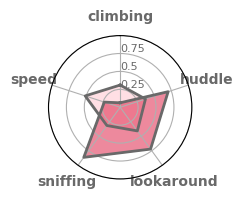

0.2574112205905225


In [35]:
# Dual radar plot between time points
learning = 'direct'
myspecific = 'female_old'

if learning == 'mediated':
        colors = {2: 'lightblue', 3: 'royalblue'}
if learning == 'direct':
        colors = {2: 'pink', 3: 'crimson'}
specifics_transmatrix = {'learning': learning}
specific_combination = {myspecific: [myspecific]}
times = [2, 3]
letter_features_dicts = {}

for time in times:
        syllables_dict = filter_data(specifics_transmatrix, directory, 6, time, target_values)
        for letter, value in specific_combination.items():
                filtered_dict = filter_syllables_dict(syllables_dict, value, target_values, 'group')
                transition_dict, states = create_transition_dict(filtered_dict, silence_diagonal=True, normalize=False)
                stationary, new_states = compute_stationary_distributions(transition_dict, states)
                stationary_dict = {letter: [stationary, new_states]}
                letter_features_dict = explain_with_deepof(stationary_dict, syllables_dict, deepof, target_values,
                                specific_combination, specifics_transmatrix, 6, time, 'group')
                letter_features_dicts[time] = letter_features_dict

polygons = dual_radar_plot(letter_features_dicts, myspecific.upper(), colors)
iou = compute_iou(polygons)
print(iou)

In [ ]:
categories = ["climbing", "huddle", "lookaround", "sniffing", "speed"]
scales = [(0, 0.2), (0, 0.2), (0, 0.3), (0, 0.1), (0, 20)]

myspecific = 'yes'
specifics_transmatrix = {'experiment': 'adol_stress'}
times = [1,2]
colors = {times[0]: 'lightgreen', times[1]: 'darkgreen'}
bins = 5

polygons = dual_radar_plot_deepof(deepof, times, target_values, specifics_transmatrix, myspecific, colors, categories, scales, bins)
iou = compute_iou(polygons)
print(iou)

In [ ]:
# Extra code to plot individual traits over time
times = [0,1,2,3,4]

all_data_dict = process_deepof(
        deepof,
        times,
        target_values,
        specifics_transmatrix,
        myspecific,
        categories,
        bins,
    )

from scipy.stats import sem
time_features_dicts = {}
for bin_num, dict_features in all_data_dict.items():
    time_features_dicts[bin_num] = {
        category: [np.mean(dict_features[category]), sem(dict_features[category])] for category in categories
        }

# Compute statistics
stats_features_dict = {}
for bin in range(len(times)):
    if bin+1 in times:
        first_bin = all_data_dict[bin]
        second_bin = all_data_dict[bin+1]
        categories_pvals = {}
        for category in categories:
            pval = pg.wilcoxon(first_bin[category], second_bin[category])['p-val'][0]
            categories_pvals[category] = pval
        stats_features_dict[f'{bin}_{bin+1}'] = categories_pvals

# Plot individual trait over time with seaborn lineplot
trait = 'sniffing'
data = []
for time, features_dict in time_features_dicts.items():
    data.append((time+1, features_dict[trait][0], features_dict[trait][1]))
df = pd.DataFrame(data, columns=['Time', 'Value', 'Error'])

sns.lineplot(x='Time', y='Value', data=df, color='darkgreen', marker='o')
plt.fill_between(df["Time"], df["Value"] - df["Error"], df["Value"] + df["Error"], color='darkgreen', alpha=0.2)
plt.xticks(df["Time"])
plt.xlabel('Time bins [min]')
plt.ylabel(trait.capitalize())

# Plot statistics
for time, categories_pvals in stats_features_dict.items():
    time_index = int(time.split('_')[0])  # Extract first number
    for category, pval in categories_pvals.items():
        if category == trait:
            x = time_index + 1.5  # Adjust x-position
            y = time_features_dicts.get(time_index, {}).get(category, [0])[0]  # Extract y-value
            if pval < 0.001:
                plt.text(x, y, "***", fontsize=12)
            elif pval < 0.01:
                plt.text(x, y, "**", fontsize=12)
            elif pval < 0.05:
                plt.text(x, y, "*", fontsize=12)

plt.show()

In [ ]:
timelapse_deepof_radar_permutation(deepof, times, target_values, specifics_transmatrix, myspecific, categories, scales, colors[times[1]], bins, pvalue="empirical")

z-score: 5.38
p-value: 3.77e-08


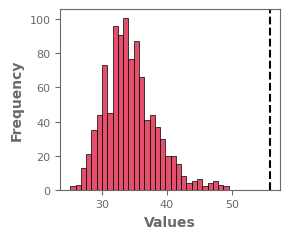

(5.377868310208583, 3.7686456400010115e-08)

In [36]:
# Perform statistics
transition_dicts = {}
for time in times:
    syllables_dict = filter_data(specifics_transmatrix, directory, 6, time, target_values)
    for value in specific_combination.values():
        filtered_dict = filter_syllables_dict(syllables_dict, value, target_values, 'group')
        transition_dict, states = create_transition_dict(filtered_dict, silence_diagonal=True, normalize=False)
        transition_dicts[time] = [transition_dict, states]

timelapse_behavior_bootstrap(transition_dicts, colors[3])

## Transition plot

In [ ]:
timelapse_circular_ind_transition_graph(transition_dicts, colors, times[0])

In [ ]:
timelapse_circular_ind_transition_graph(transition_dicts, colors, times[1])

<Axes: >

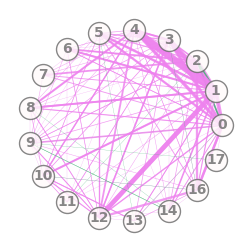

In [37]:
colors = {2: 'violet', 3: 'mediumseagreen'}
# 2 for downregulated, 3 for upregulated

measures_direct = analyze_transition_changes(transition_dicts)
timelapse_circular_transition_graph(transition_dicts, colors)

In [ ]:
timelapse_heatmap_transition_graph(transition_dicts, colors, period='ON', vmax=5)

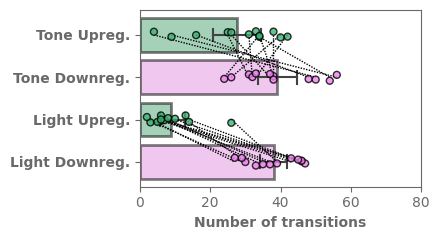

In [38]:
custom_labels = ['Tone Upreg.', 'Tone Downreg.', 'Light Upreg.', 'Light Downreg.']

category = []
value = []
for measures, tag in zip([measures_direct, measures_mediated], ['light', 'tone']):
    category.extend([f'up_{tag}'] * len(measures['upregulated']) + [f'down_{tag}'] * len(measures['downregulated']))
    value.extend(measures['upregulated'] + measures['downregulated'])

all_data = {'Category': category, 'Value': value}
df = pd.DataFrame(all_data)

# Create figure
plt.figure(figsize=(4.5, 2.5))

# Horizontal bars
sns.barplot(
    y='Category', x='Value', data=df,
    palette=['mediumseagreen', 'violet', 'mediumseagreen', 'violet'], alpha=0.5, edgecolor='black',
    order=['up_tone', 'down_tone', 'up_light', 'down_light'],
    capsize=0.3,       # Controls the width of the error bar caps
    errwidth=1.5,    # Controls the thickness of the error bars
    linewidth=2      # Controls the width of the bars themselves
)

# Horizontal Stripplot
sns.stripplot(
    y='Category', x='Value', data=df, jitter=True, 
    palette=['mediumseagreen', 'violet', 'mediumseagreen', 'violet'], alpha=0.8, edgecolor='black', linewidth=1,
    order=['up_tone', 'down_tone', 'up_light', 'down_light'],
)

# Plot connected dots
for tone1, tone2 in zip(df[df.Category == 'up_tone']['Value'].values,
                        df[df.Category == 'down_tone']['Value'].values):
    plt.plot([tone1, tone2], [0, 1], color='k', linestyle=(0, (1, 1)), linewidth=1)

for light1, light2 in zip(df[df.Category == 'up_light']['Value'].values,
                        df[df.Category == 'down_light']['Value'].values):
    plt.plot([light1, light2], [2, 3], color='k', linestyle=(0, (1, 1)), linewidth=1)

# Labels
plt.ylabel("", color='dimgrey')
plt.xlabel("Number of transitions", color='dimgrey', fontsize=10, fontweight='bold')
plt.yticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, fontweight='bold')
plt.xlim(0,80)

# Change axis colors to dark grey
plt.gca().spines['top'].set_color('dimgrey')
plt.gca().spines['right'].set_color('dimgrey')
plt.gca().spines['left'].set_color('dimgrey')
plt.gca().spines['bottom'].set_color('dimgrey')

plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

plt.tight_layout()
plt.show()

In [40]:
# Stats
group_tag = 'light'
group1 = df[df['Category'] == f'up_{group_tag}']['Value']
group2 = df[df['Category'] == f'down_{group_tag}']['Value']

differences = [g2 - g1 for g1, g2 in zip(group1, group2)]
print('Normality:\n', pg.normality(differences))

print('Paired t-test:\n', pg.ttest(group1, group2, paired=True))
print('Wilcoxon:\n', pg.wilcoxon(group1, group2))

Normality:
           W      pval  normal
0  0.953385  0.686875    True
Paired t-test:
                 T  dof alternative         p-val             CI95%   cohen-d  \
T-test -11.677022   11   two-sided  1.539080e-07  [-34.76, -23.74]  4.236778   

             BF10  power  
T-test  8.823e+04    1.0  
Wilcoxon:
           W-val alternative     p-val  RBC  CLES
Wilcoxon    0.0   two-sided  0.000488 -1.0   0.0


# AD/Stress analysis supervised

In [ ]:
root = Path('//folder/becell/Lab Projects/Stress_Cort_Adolesc_Llavor/OF analysis/entraining habituation in OF/')

# Upload the conditions
txt_path = root / "conditions.csv"
target_values = pd.read_csv(txt_path)

# Upload the DeepOF annotations
deepof_path = root / "supervised_annotation.pkl"
with open(deepof_path, 'rb') as file:
    deepof = pkl.load(file)

In [ ]:
# Dual radar plot between WT and APP specifics
specifics_transmatrix = {'experiment': 'adol_stress'}
groups = ['yes', 'no']
colors = {groups[0]: 'lightgreen', groups[1]: 'darkgreen'}
bin_num = 0 # Start from 0
num_bins = 1

categories = ["climbing", "huddle", "lookaround", "sniffing", "speed"]
scales = [(0, 0.2), (0, 0.2), (0, 0.25), (0, 0.12), (6, 15)]

# Specify position in the OF
bodypart = 'Nose'
area = 'center'

In [ ]:
# Add position on the OF
data_directory = root / "positionOF"
for file in data_directory.glob('*.csv'):
    id = file.stem.split('DLC_')[0]
    table = pd.read_csv(file)
    bodyparts = list(set(table.points))
    zones = list(set(table.zone))
    for bodypart in bodyparts:
        table_bodypart = table[table.points == bodypart]
        table_bodypart = table_bodypart.groupby('seconds')['zone'].apply(lambda x: list(x.dropna())).reset_index()
        for myzone in zones:
            table_bodypart[myzone] = table_bodypart['zone'].apply(lambda x: myzone in x)
        table_bodypart = table_bodypart.reset_index(drop=True)
        deepof[id] = deepof[id].reset_index(drop=True)
        if len(deepof[id]) == len(table_bodypart):
            for myzone in zones:
                deepof[id][f'{bodypart}_{myzone}'] = table_bodypart[myzone].to_numpy()
        else:
            print(f"Lengths do not match for {id}")

In [ ]:
# Process DeepOF =======================================================================================================
# Filter specifics
for mycolumn, specific in specifics_transmatrix.items():
    filtered_targets = target_values[target_values[mycolumn] == specific]

ids_group1 = filtered_targets[filtered_targets.group == 'yes']['experiment_id'].tolist()
ids_group2 = filtered_targets[filtered_targets.group == 'no']['experiment_id'].tolist()

# Filter the data by position in the OF
if bodypart and area:
    for id in ids_group1 + ids_group2:
        if id in deepof.keys():
            deepof[id] = deepof[id][deepof[id][f'{bodypart}_{area}'] == True]

# Filter by group
letter_deepof_group1 = {id: deepof[id] for id in ids_group1 if id in deepof.keys()}
letter_deepof_group2 = {id: deepof[id] for id in ids_group2 if id in deepof.keys()}

# Compute mean length of the features
frames_group1 = [len(table) for table in letter_deepof_group1.values()]
frames_group2 = [len(table) for table in letter_deepof_group2.values()]
df = pd.DataFrame({'Group': ['yes'] * len(frames_group1) + ['no'] * len(frames_group2), 'Frames': frames_group1 + frames_group2})
sns.scatterplot(x='Group', y='Frames', data=df)

# Filter by time bin
group_features_dicts = {}
for group, letter_deepof in zip(groups, [letter_deepof_group1, letter_deepof_group2]):
    cut_deepof = {}
    for id, table in letter_deepof.items():
        if not table.empty:
            bin_size = len(table) // num_bins
            start_index = bin_num * bin_size + bin_num
            end_index = start_index + bin_size
            cut_table = table.iloc[start_index:end_index]
            cut_deepof[id] = cut_table

    dict_features = {}
    for category in categories:
        averages = [table[category].mean() for table in cut_deepof.values()]
        dict_features[category] = averages

    group_features_dicts[group] = dict_features

In [ ]:
# Radar plot ==========================================================================================================

mean_features_dicts = {}
for group, dict_features in group_features_dicts.items():
    mean_features_dicts[group] = {
        category: np.mean(dict_features[category]) for category in categories
    }

N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# ------- PART 1: Create background
fig, ax = plt.subplots(figsize=(2.5, 2.5), subplot_kw={"polar": True})
plt.xticks(angles[:-1], categories, color="dimgray", fontsize=10, fontweight="bold")
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
plt.yticks(
    [0.25, 0.5, 0.75, 1], ["0.25", "0.5", "0.75", ""], color="dimgray", size=8
)
plt.ylim(0, 1)

# ------- PART 2: Add plots
polygons = {}
for time, letter_features_dict in mean_features_dicts.items():
    values = list(letter_features_dict.values())

    normalized_values = [
        (val - scale[0]) / (scale[1] - scale[0])
        for val, scale in zip(values, scales)
    ]
    polygons[time] = normalized_values
    normalized_values += normalized_values[:1]
    ax.plot(
        angles,
        normalized_values,
        linewidth=2,
        linestyle="solid",
        alpha=1,
        color="dimgray",
    )
    ax.fill(angles, normalized_values, color=colors[time], alpha=0.5)

# Tidy up the layout
plt.tight_layout()
plt.show()

# Compute IoU
iou = compute_iou(polygons)
print(iou)

# AD/Stress analysis unsupervised

In [ ]:
root = Path('//folder/becell/Lab Projects/Stress_Cort_Adolesc_Llavor/OF analysis/entraining habituation in OF/')
directory = root / "csv_moseq"

# Upload the conditions
txt_path = root / "conditions.csv"
target_values = pd.read_csv(txt_path)

# Dual radar plot between WT and APP specifics
specifics_transmatrix = {'experiment': 'adol_stress'}
groups = ['yes', 'no']
bin_num = 0 # Start from 0
num_bins = 5

In [ ]:
def create_transition_dict_alzheimer(groups, specifics_transmatrix, directory, num_bins, bin_num, target_values):
    transition_dicts = {}
    for group in groups:
        # Update the specifics
        specifics = specifics_transmatrix.copy()
        specifics.update({'control': group})

        # Filter specifics
        syllables_dict = filter_data(specifics, directory, num_bins, bin_num, target_values)
        
        # Create the transition matrix
        transition_dict, states = create_transition_dict(syllables_dict, silence_diagonal=True, normalize=False)
        transition_dicts[group] = [transition_dict, states]
    
    return transition_dicts

transition_dicts = create_transition_dict_alzheimer(groups, specifics_transmatrix, directory, num_bins, bin_num, target_values)
zscore, p_value = timelapse_behavior_bootstrap(transition_dicts, 'darkgreen')

In [ ]:
colors = {2: 'violet', 3: 'mediumseagreen'}
# 2 for downregulated, 3 for upregulated

measures_direct = analyze_transition_changes(transition_dicts)
timelapse_circular_transition_graph(transition_dicts, colors)

In [ ]:
# Plot zscores over time
p_values = []
for my_bin_num in range(5):
    transition_dicts = create_transition_dict_alzheimer(groups, specifics_transmatrix, directory, num_bins, my_bin_num, target_values)
    zscore, p_value = timelapse_behavior_bootstrap(transition_dicts, 'darkgreen')
    p_values.append(p_value)

plt.plot(p_values)
plt.show()